In [18]:
import numpy as np
from sklearn.datasets import load_iris, make_blobs, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from utils import *

# Number of classes
nn = 3

# dataset_name = "digit_0_2"

X = load_iris().data[:,:2]
y = load_iris()['target']

# n_samples = 3*40
# X, y = make_blobs(n_samples=160, centers=nn, random_state=42)


# digits = load_digits(n_class=nn)
# X, y = digits.data, digits.target

# if dataset_name == "digit_0_2":
#     # Data preprocessing using standard scaling
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)

#     # Dimensionality reduction using t-SNE
#     tsne = TSNE(n_components=2, perplexity=10, learning_rate=200, random_state=42)
#     X = tsne.fit_transform(X_scaled)

# Initialize the lists to hold the split data
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, train_size=90, random_state=101)

# Splitting the data
for i in range(nn):
    # Filter the data for the current class
    X_class = X[y == i]
    y_class = y[y == i]
    
    # Perform the split
    X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
        X_class, y_class, test_size=40, train_size=10, random_state=151
    )
    
    # Append the current class's split to the lists
    X_train_list.append(X_class_train)
    X_test_list.append(X_class_test)
    y_train_list.append(y_class_train)
    y_test_list.append(y_class_test)

# Concatenate all class splits together
X_train = np.concatenate(X_train_list)
X_test = np.concatenate(X_test_list)
y_train = np.concatenate(y_train_list)
y_test = np.concatenate(y_test_list)

print(f'Dataset split summary:')
print(f'Training set size: {X_train.shape[0]}')
print(f'Testing set size: {X_test.shape[0]}')

Dataset split summary:
Training set size: 30
Testing set size: 120


In [19]:
gamma = 2 #Iris Petal
# gamma = 0.1 #Blob
# gamma = 0.001 #Digit 0~3
C = 1

In [20]:
from sklearn.metrics import classification_report, accuracy_score
from smo_svm import smo_SVM, smo_OneVsAllClassifier

# Train Multiclass SVM
smo_solver = smo_OneVsAllClassifier(
    solver=smo_SVM,
    num_classes=nn,
    c=C,
    kkt_thr=1e-4,
    max_iter=1e5,
    kernel_type='rbf',
    gamma_rbf=gamma
)

smo_solver.fit(X_train, y_train)

# Predict
y_pred = smo_solver.predict(X_test)
yt_pred= smo_solver.predict(X_train)

# Performance analysis
smo_test_accuracy = accuracy_score(y_test, y_pred)*100
smo_train_accuracy = accuracy_score(y_train, yt_pred)*100
print(smo_test_accuracy)
print(smo_train_accuracy)
# print(classification_report(y_test, y_pred))

# plot_figure(smo_solver, X_tsne, y, nn, X_test, X_train, y_test, y_train, filename= "results\iris_SMO")

SVM training using SMO algorithm - START
Training summary: 334 iterations, 13 supprts vectors
SVM training using SMO algorithm - DONE!
SVM training using SMO algorithm - START
Training summary: 264 iterations, 21 supprts vectors
SVM training using SMO algorithm - DONE!
SVM training using SMO algorithm - START
Training summary: 222 iterations, 22 supprts vectors
SVM training using SMO algorithm - DONE!
78.33333333333333
86.66666666666667


Training classifier 0...
solving...
K,N 2 30
self.intercept -1.1776702522134854
Training classifier 1...
solving...
K,N 2 30
self.intercept -1.5492799134164246
Training classifier 2...
solving...
K,N 2 30
self.intercept -1.6828244787889488
-------------------------
SA
train accuracy :  [86.66666666666667]
mean :  86.66666666666667
standard deviation :  0.0
test accuracy :  [76.66666666666667]
76.66666666666667
0.0
-------------------------


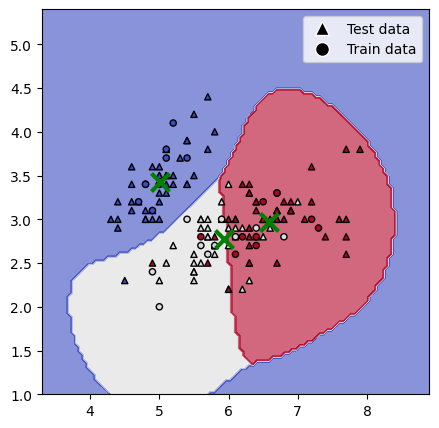

In [24]:
from sklearn.metrics import classification_report, accuracy_score
from qsvm import *

params = {
    "data": X_train,
    "label": y_train,
    "B": 2,
    "K": 2,
    "Xi": 1,
    "gamma": gamma,
    "C": C,
    "kernel": "rbf",
    "optimizer": "SA",
    "vis" : 0
}

# Initialize and train the classifier
sa_OvR = OneVsRestClassifier(class_num=nn, classifier=qSVM, params=params)
sa_OvR.solve(X_train, y_train)

sa_test = []
sa_train = []
NN = 1
for i in range(NN):
    # Predict
    sa_predict = sa_OvR.predict(X_test)
    sa_t_pred= sa_OvR.predict(X_train)

    # Performance analysis
    sa_test_accuracy = accuracy_score(y_test, sa_predict)*100
    sa_training_accuracy = accuracy_score(y_train, sa_t_pred)*100

    sa_test.append(sa_test_accuracy)
    sa_train.append(sa_training_accuracy)

print("-------------------------")
print("SA")
print("train accuracy : ", sa_train)
print("mean : ", np.mean(sa_train))
print("standard deviation : ", np.std(sa_train))
print("test accuracy : ", sa_test)
print(np.mean(sa_test))
print(np.std(sa_test))
print("-------------------------")

plot_figure(sa_OvR, X, y, nn, X_test, X_train, y_test, y_train, filename= f"results\{dataset_name}_SA1")
# print(classification_report(y_test, sa_predict))

In [22]:
from qsvm import *
from utils import *

NN = 1
mtqa_test = []
mtqa_train = []
qa_test = []
qa_train = []
for i in range(NN):
    params = {
        "data": X_train,
        "label": y_train,
        "B": 2,
        "K": 2,
        "Xi": 1,
        "gamma": gamma,
        "C": C,
        "kernel": "rbf",
        "optimizer": "MTQA",
        "qubo_list": None,
        "vis": 1
    }

    # Initialize and train the classifier
    mtqa_OvR = MTQA_OneVsRestClassifier(class_num=nn, classifier=qSVM, params=params)
    _, embedding_list, TotalQubo, Qubo_list = mtqa_OvR.solve(X_train, y_train)

    save_embedding(embedding_list, "iris_petal")
    save_TotalQubo(TotalQubo, "iris_petal")
    save_qubo_list(Qubo_list, "iris_petal")

    # Predict
    mtqa_predict = mtqa_OvR.predict(X_test)
    mtqa_t_pred= mtqa_OvR.predict(X_train)

    # Performance analysis
    mtqa_test_accuracy = accuracy_score(y_test, mtqa_predict)*100
    mtqa_training_accuracy = accuracy_score(y_train, mtqa_t_pred)*100

    mtqa_test.append(mtqa_test_accuracy)
    mtqa_train.append(mtqa_training_accuracy)

    qubo_list = load_qubo_list("iris_petal")
    emb = load_embedding("iris_petal")

    params = {
        "data": X_train,
        "label": y_train,
        "B": 2,
        "K": 2,
        "Xi": 1,
        "gamma": gamma,
        "C": C,
        "kernel": "rbf",
        "optimizer": "QA",
        "qubo_list" : qubo_list,
        "embeddings" : emb,
        "vis" : 0
    }

    # Initialize and train the classifier
    qa_OvR = OneVsRestClassifier(class_num=nn, classifier=qSVM, params=params)
    qa_OvR.solve(X_train, y_train)

    # Predict
    qa_predict = qa_OvR.predict(X_test)
    qa_t_pred= qa_OvR.predict(X_train)

    # Performance analysis
    qa_test_accuracy = accuracy_score(y_test, qa_predict)*100
    qa_training_accuracy = accuracy_score(y_train, qa_t_pred)*100

    qa_test.append(qa_test_accuracy)
    qa_train.append(qa_training_accuracy)

print("-------------------------")
print("QA")
print("train accuracy : ", qa_train)
print("mean : ", np.mean(qa_train))
print("standard deviation : ", np.std(qa_train))
print("test accuracy : ", qa_test)
print(np.mean(qa_test))
print(np.std(qa_test))

print("-------------------------")
print("MTQA")
print("train accuracy : ", mtqa_train)
print("mean : ", np.mean(mtqa_train))
print("standard deviation : ", np.std(mtqa_train))
print("test accuracy : ", mtqa_test)
print("mean : ",np.mean(mtqa_test))
print("standard deviation : ",np.std(mtqa_test))
print("-------------------------")

self.intercept 10.135522440728186
self.intercept 6.29703917983104
self.intercept -0.6927114457930643
Training classifier 0...
solving...
K,N 2 30
self.intercept -0.8170597062110204
Training classifier 1...
solving...
K,N 2 30
self.intercept -1.3706261191466411
Training classifier 2...
solving...
K,N 2 30
self.intercept -0.8535467928112537
-------------------------
QA
train accuracy :  [86.66666666666667]
mean :  86.66666666666667
standard deviation :  0.0
test accuracy :  [76.66666666666667]
76.66666666666667
0.0
-------------------------
MTQA
train accuracy :  [86.66666666666667]
mean :  86.66666666666667
standard deviation :  0.0
test accuracy :  [72.5]
mean :  72.5
standard deviation :  0.0
-------------------------


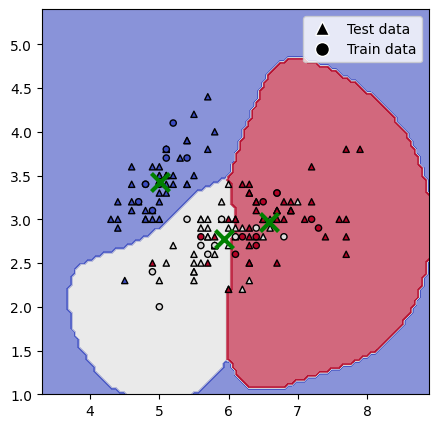

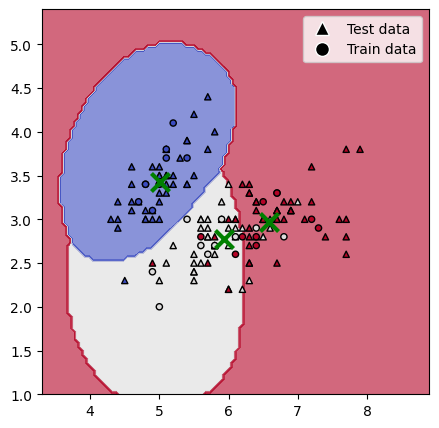

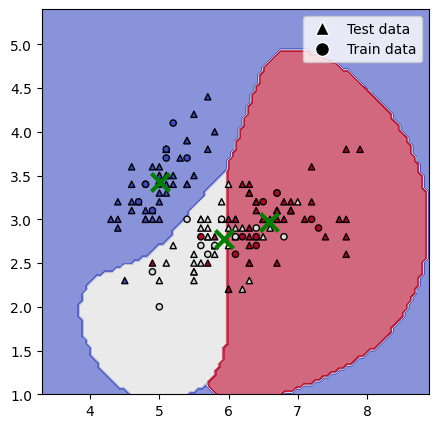

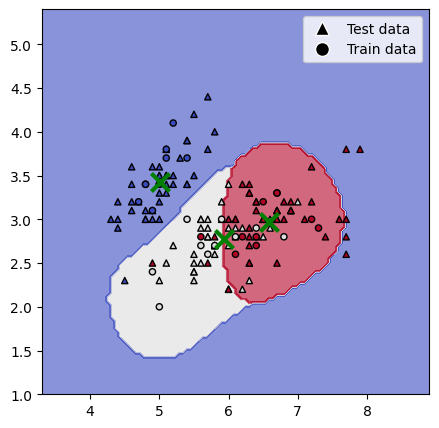

In [23]:
# dataset_name = "Blob4"
dataset_name = "iris_sepal"

plot_figure(smo_solver, X, y, nn, X_test, X_train, y_test, y_train, filename= f"results\{dataset_name}_SMO")
plot_figure(sa_OvR, X, y, nn, X_test, X_train, y_test, y_train, filename= f"results\{dataset_name}_SA")
plot_figure(qa_OvR, X, y, nn, X_test, X_train, y_test, y_train, filename= f"results\{dataset_name}_QA")
plot_figure(mtqa_OvR, X, y, nn, X_test, X_train, y_test, y_train, filename= f"results\{dataset_name}_MTQA")

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def make_meshgrid(x, y, h=.2):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 80), np.linspace(y_min, y_max, 80))
    return xx, yy

# Function to plot decision boundaries
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Set up plot figures
fig, sub = plt.subplots(1, 2,figsize=(16, 8))

# Create meshgrid
X0, X1 = X_tsne[:, 0], X_tsne[:, 1]
xx, yy = make_meshgrid(X0, X1)

# Define colormap for plotting
coolwarm = plt.cm.coolwarm
colors = coolwarm(np.linspace(0, 1, nn))
cm = ListedColormap(colors)

# Plot decision boundaries and data points for qSVM
ax = sub[0]
contour = plot_contours(ax, sa_one_vs_rest, xx, yy, cmap=cm, alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, marker='^', edgecolors='k', s=20)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm, marker='o', edgecolors='k', s=20)

# Compute and plot centroids
centroids = np.array([X_tsne[y == i].mean(axis=0) for i in np.unique(y)])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='g', zorder=10)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(f"SA Decision Boundary Accuracy: {sa_test_accuracy:.2f}%")

# Add labels
labels = ['Test data', 'Train data']
handles = [plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='k', markersize=10, linestyle=''),
           plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='k', markersize=10, linestyle='')]
ax.legend(handles, labels)

# Plot decision boundaries and data points for classical SVM
ax = sub[1]
contour = plot_contours(ax, smo_solver, xx, yy, cmap=cm, alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, marker='^', edgecolors='k', s=20)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm, marker='o', edgecolors='k', s=20)

# Compute and plot centroids
centroids = np.array([X_tsne[y == i].mean(axis=0) for i in np.unique(y)])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='g', zorder=10)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(f"Classic SVM Decision Boundary Accuracy: {smo_test_accuracy:.2f}%")

# Add labels
labels = ['Test data', 'Train data']
handles = [plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='k', markersize=10, linestyle=''),
           plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='k', markersize=10, linestyle='')]
ax.legend(handles, labels)

# Colorbar
# cbar = fig.colorbar(contour) #, ax=sub.ravel().tolist(), fraction=0.046, pad=0.04
# cbar.set_ticks(np.arange(0, nn))  # Setting ticks for nn classes
# cbar.set_ticklabels(np.arange(0, nn))  # Setting tick labels

plt.savefig("results\iris_SA_SMO.png",  bbox_inches='tight', dpi = 300)

plt.show()

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def make_meshgrid(x, y, h=.2):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 80), np.linspace(y_min, y_max, 80))
    return xx, yy

# Function to plot decision boundaries
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Set up plot figures
fig, sub = plt.subplots(1, 2,figsize=(16, 8))
plt.subplots_adjust(wspace=0.1, hspace=0.4)

# Create meshgrid
X0, X1 = X_tsne[:, 0], X_tsne[:, 1]
xx, yy = make_meshgrid(X0, X1)

# Define colormap for plotting
coolwarm = plt.cm.coolwarm
colors = coolwarm(np.linspace(0, 1, nn))
cm = ListedColormap(colors)

# Plot decision boundaries and data points for qSVM
ax = sub[0]
contour = plot_contours(ax, qa_OvR, xx, yy, cmap=cm, alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, marker='^', edgecolors='k', s=20)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm, marker='o', edgecolors='k', s=20)

# Compute and plot centroids
centroids = np.array([X_tsne[y == i].mean(axis=0) for i in np.unique(y)])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='g', zorder=10)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(f"QA Decision Boundary Accuracy: {qa_test_accuracy*100:.2f}%")

# Add labels
labels = ['Test data', 'Train data']
handles = [plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='k', markersize=10, linestyle=''),
           plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='k', markersize=10, linestyle='')]
ax.legend(handles, labels)

# Plot decision boundaries and data points for classical SVM
ax = sub[1]
contour = plot_contours(ax, mtqa_OvR, xx, yy, cmap=cm, alpha=0.6)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm, marker='^', edgecolors='k', s=20)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm, marker='o', edgecolors='k', s=20)

# Compute and plot centroids
centroids = np.array([X_tsne[y == i].mean(axis=0) for i in np.unique(y)])
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='g', zorder=10)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(f"MTQA Decision Boundary Accuracy: {mtqa_test_accuracy*100:.2f}%")

# Add labels
labels = ['Test data', 'Train data']
handles = [plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='k', markersize=10, linestyle=''),
           plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='k', markersize=10, linestyle='')]
ax.legend(handles, labels)

# Colorbar
# cbar = fig.colorbar(contour) #, ax=sub.ravel().tolist(), fraction=0.046, pad=0.04
# cbar.set_ticks(np.arange(0, nn))  # Setting ticks for nn classes
# cbar.set_ticklabels(np.arange(0, nn))  # Setting tick labels

plt.savefig("results\iris_QA_MTQA.png",  bbox_inches='tight', dpi = 300)

plt.show()

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, svm_pred)
disp.figure_.suptitle("Classic SMO onfusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.savefig("results\iris_smo_confusion_matrix.png",  bbox_inches='tight', dpi = 300)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# First, predict the test set labels
qsvm_predictions = sa_one_vs_rest.predict(X_test)

# Now, compute the confusion matrix using sklearn's functionality
cm = confusion_matrix(y_test, qsvm_predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(values_format='d')  # 'd' for integer formatting
plt.title("SA Confusion Matrix")

plt.savefig("results\iris_sa_confusion_matrix.png",  bbox_inches='tight', dpi = 300)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# First, predict the test set labels
qsvm_predictions = mtqa_OvR.predict(X_test)

# Now, compute the confusion matrix using sklearn's functionality
cm = confusion_matrix(y_test, qsvm_predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(values_format='d')  # 'd' for integer formatting
plt.title("MTQA Confusion Matrix")

plt.savefig("results\iris_mtqa_confusion_matrix.png",  bbox_inches='tight', dpi = 300)

plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# First, predict the test set labels
qsvm_predictions = qa_OvR.predict(X_test)

# Now, compute the confusion matrix using sklearn's functionality
cm = confusion_matrix(y_test, qsvm_predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(values_format='d')  # 'd' for integer formatting
plt.title("QA Confusion Matrix")

plt.savefig("results\digit_0_3_qa_confusion_matrix.png",  bbox_inches='tight', dpi = 300)

plt.show()


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

# Initialize the classical SVM classifier
svm_classifier = SVC(kernel='rbf', gamma=gamma)

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Evaluate the classifier
svm_pred = svm_classifier.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
print(f"Classical SVM Test Accuracy: {svm_accuracy*100:.2f}%")